# Indodax Pattern Analysis

Melihat pattern berdasarkan data historical Indodax.

## Jam berapa waktu yang tepat untuk beli?

Aku pengen tau waktu yang pas untuk beli.



In [ ]:
# Get current date
from datetime import datetime, date, timezone, timedelta

# current_datetime = datetime.now(tz=timezone(offset=timedelta(hours=7)))
# print("current_datetime", current_datetime)
# print("current_datetime.year", current_datetime.year)
# print("current_datetime.month", current_datetime.month)
# print("current_datetime.day", current_datetime.day)

# current_date = date(current_datetime.year, current_datetime.month, current_datetime.day)
# print(current_date.timestamp())

# aku pengen dapet tanggal 05/03/2021 UTC+7
# current_datetime = datetime.now(tz=timezone(offset=timedelta(hours=7)))
# current_date = current_datetime.replace(hour=0, minute=0, second=0)
# end_date = current_date - timedelta(seconds=1)
# start_date = current_date - timedelta(days=21)

# print("current_date", current_datetime.timestamp())
# print("end_date", end_date.timestamp()) # harusnya tgl 4 jam 23:59:59
# print("start_date", start_date.timestamp()) # harusnya tgl 4 jam 23:59:59

# print("current_date", current_date)
# print("end_date", end_date)
# print("start_date", start_date)

current_date 1614930219.404076
end_date 1614877199.404076
start_date 1613062800.404076
current_date 2021-03-05 00:00:00.404076+07:00
end_date 2021-03-04 23:59:59.404076+07:00
start_date 2021-02-12 00:00:00.404076+07:00


In [ ]:
# Get data from the api
import requests
from datetime import datetime, timedelta

import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def plot_data(ticker: str, interval: int) -> None:
  # Get the history data
  start_date = datetime.utcnow() - timedelta(days=interval)
  end_date = datetime.utcnow()
  dailyResponse = requests.get("https://indodax.com/tradingview/history", params={"symbol": ticker, "resolution": "D", "from": start_date.timestamp(), "to": end_date.timestamp()})
  dailyData = dailyResponse.json()

  hourlyResponse = requests.get("https://indodax.com/tradingview/history", params={"symbol": ticker, "resolution": 60, "from": start_date.timestamp(), "to": end_date.timestamp()})
  hourlyData = hourlyResponse.json()
  
  map_date_to_low_price = {}
  map_date_to_high_price = {}

  for i in range(len(dailyData["t"])):
    data_time = datetime.fromtimestamp(dailyData["t"][i])
    lowest_price = dailyData["l"][i]
    highest_price = dailyData["h"][i]
    key = "{}-{}-{}".format(data_time.year, data_time.month, data_time.day)
    map_date_to_low_price[key] = lowest_price
    map_date_to_high_price[key] = highest_price

  map_date_lowest_price_to_hour = {}
  map_date_highest_price_to_hour = {}

  # print("hour_utc\t\tlowest_price")
  for i in range(len(hourlyData["t"])):
    data_time = datetime.fromtimestamp(hourlyData["t"][i])
    lowest_price = hourlyData["l"][i]
    highest_price = hourlyData["h"][i]
    # print("{}\t{}".format(data_time, lowest_price))
    low_key = "{}-{}-{}-{}".format(data_time.year, data_time.month, data_time.day, lowest_price)
    high_key = "{}-{}-{}-{}".format(data_time.year, data_time.month, data_time.day, highest_price)
    map_date_lowest_price_to_hour[low_key] = data_time.hour
    map_date_highest_price_to_hour[high_key] = data_time.hour

  # Count the frequency
  # map hour to lowest price count
  hour_lowest_price = {}
  hour_highest_price = {}

  for date in map_date_to_low_price:
    key = "{}-{}".format(date, map_date_to_low_price[date])
    # Convert to UTC+7
    hour_key = "{}".format((map_date_lowest_price_to_hour[key] + 7) % 24)
    if hour_key in hour_lowest_price:
      hour_lowest_price[hour_key] += 1
    else:
      hour_lowest_price[hour_key] = 1

  for date in map_date_to_high_price:
    key = "{}-{}".format(date, map_date_to_high_price[date])
    # Convert to UTC+7
    hour_key = "{}".format((map_date_highest_price_to_hour[key] + 7) % 24)
    if hour_key in hour_highest_price:
      hour_highest_price[hour_key] += 1
    else:
      hour_highest_price[hour_key] = 1

  hour_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
  lowest_price = [hour_lowest_price.get(str(label), 0) for label in hour_labels]
  highest_price = [hour_highest_price.get(str(label), 0)  for label in hour_labels] 

  x = np.arange(len(hour_labels))  # the label locations
  width = 0.3 # the width of the bars

  fig, ax = plt.subplots()
  rects1 = ax.bar(x - width/2, lowest_price, width, label='Lowest Price')
  rects2 = ax.bar(x + width/2, highest_price, width, label='Highest Price')

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel('Frequency lowest/highest price appear')
  ax.set_title('Data Harga {} Tiap Jam dalam {} hari terakhir'.format(ticker, interval))
  ax.set_xticks(x)
  ax.set_xticklabels(hour_labels)
  ax.legend()


  def autolabel(rects):
      """Attach a text label above each bar in *rects*, displaying its height."""
      for rect in rects:
          height = rect.get_height()
          ax.annotate('{}'.format(height),
                      xy=(rect.get_x() + rect.get_width() / 2, height),
                      xytext=(0, 3),  # 3 points vertical offset
                      textcoords="offset points",
                      ha='center', va='bottom')


  autolabel(rects1)
  autolabel(rects2)

  fig.tight_layout()
  fig.set_size_inches(18.5, 10.5)

  plt.show()





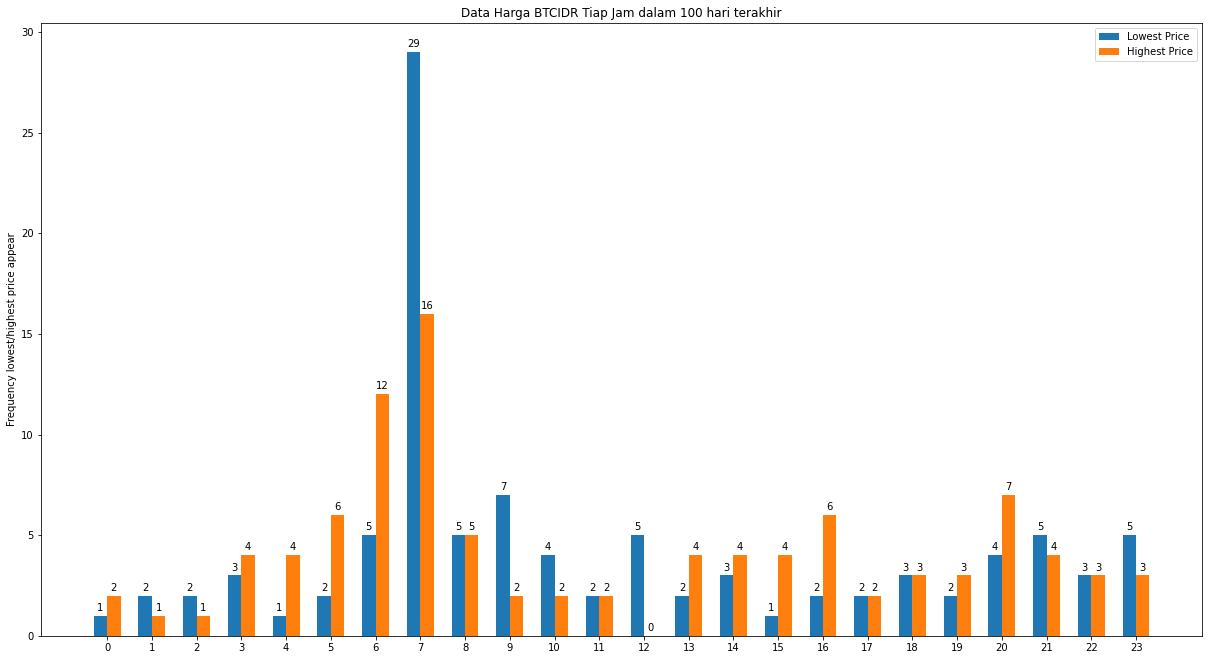

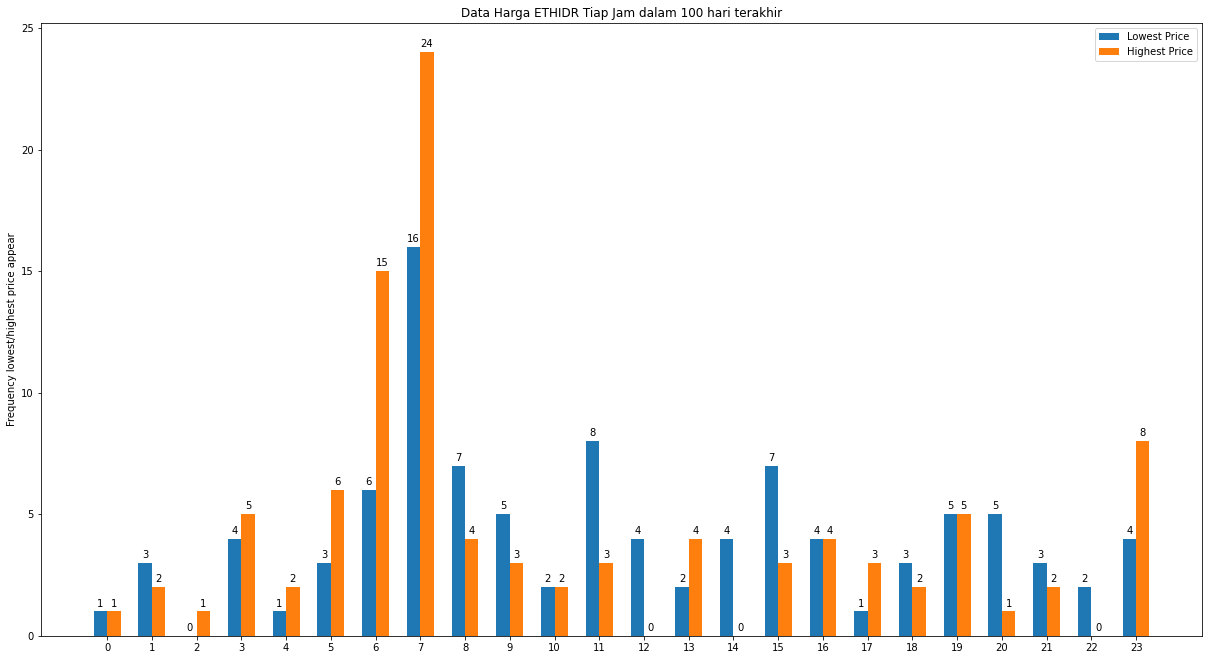

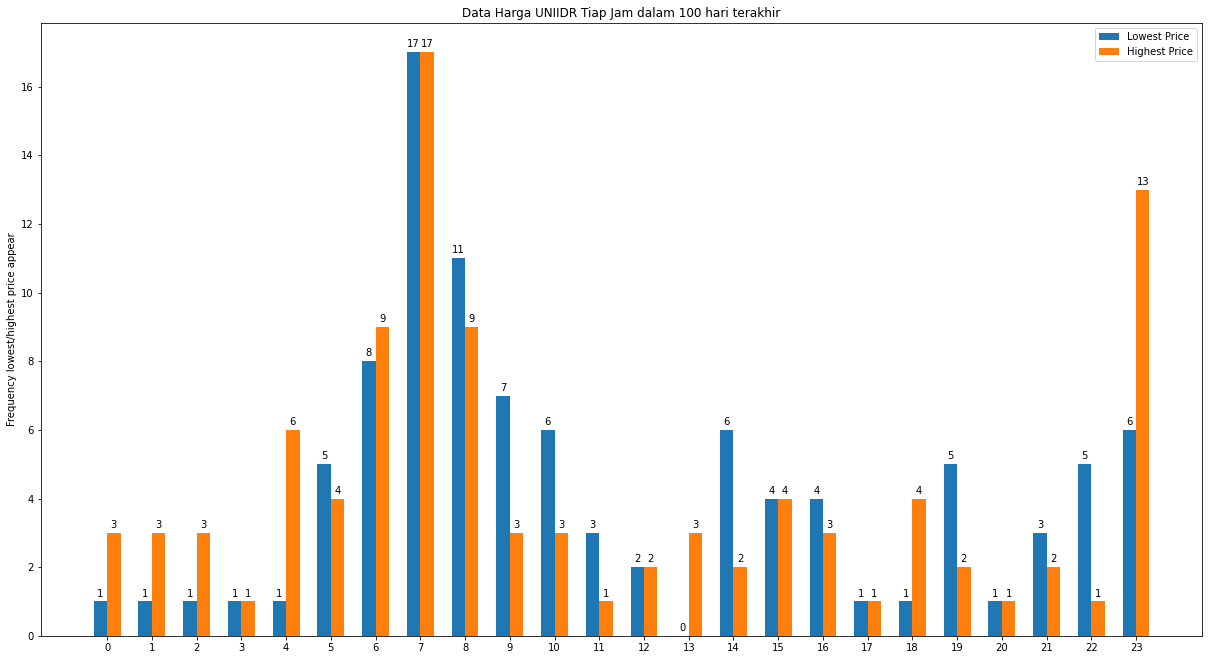

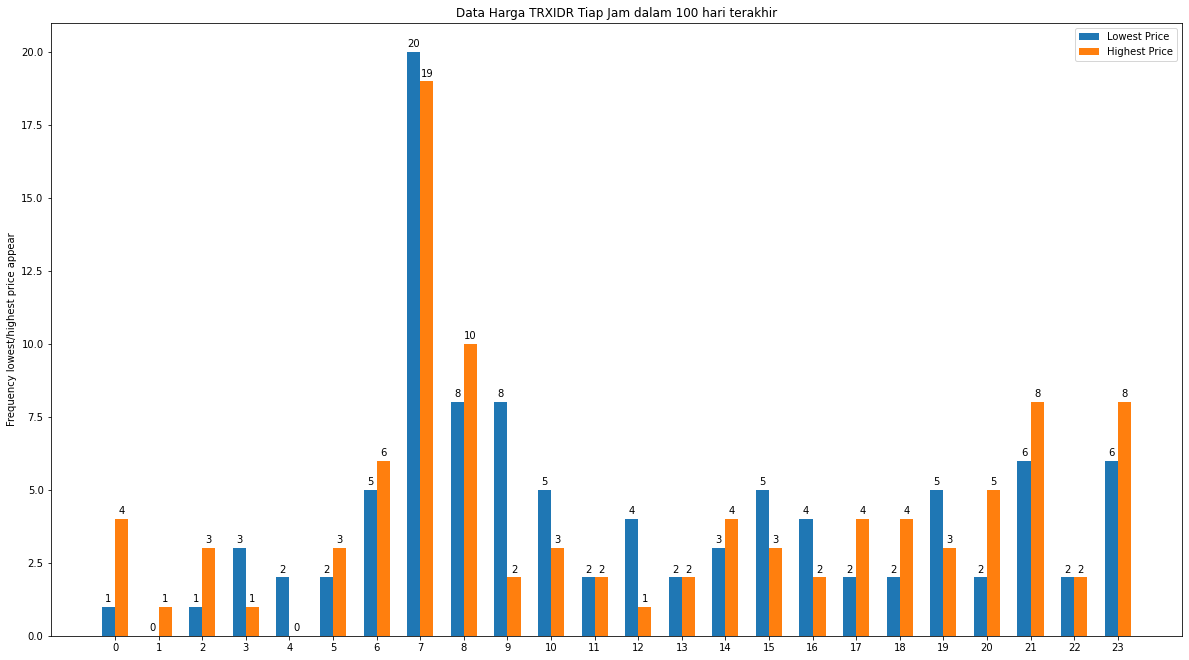

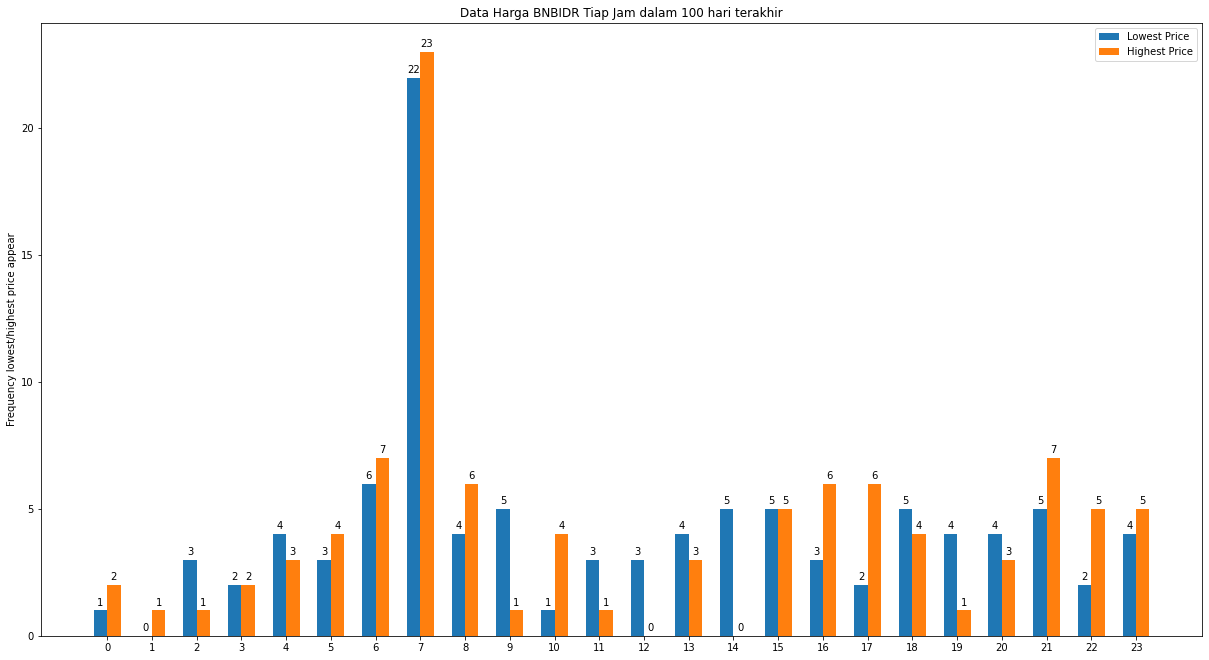

In [ ]:
TICKERS = ["BTCIDR", "ETHIDR", "UNIIDR", "TRXIDR", "BNBIDR"]
INTERVAL_DAYS = 100 

for ticker in TICKERS:
  plot_data(ticker, INTERVAL_DAYS)